In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# XGBoost (Best model)
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")
import joblib

In [2]:
df = pd.read_csv("../Data/alltypesofdisease.csv")
df.head()


,Patient_ID,Age,Gender,Symptoms,Symptom_Count,Disease
0,1,29,Male,"fever, back pain, shortness of breath",3,Allergy
1,2,76,Female,"insomnia, back pain, weight loss",3,Thyroid Disorder
2,3,78,Male,"sore throat, vomiting, diarrhea",3,Influenza
3,4,58,Other,"blurred vision, depression, weight loss, muscl...",4,Stroke
4,5,55,Female,"swelling, appetite loss, nausea",3,Heart Disease


In [3]:
df.shape


(25000, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Patient_ID     25000 non-null  int64 
 1   Age            25000 non-null  int64 
 2   Gender         25000 non-null  object
 3   Symptoms       25000 non-null  object
 4   Symptom_Count  25000 non-null  int64 
 5   Disease        25000 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.1+ MB


In [5]:
df.isnull().sum()


Patient_ID       0
Age              0
Gender           0
Symptoms         0
Symptom_Count    0
Disease          0
dtype: int64

In [6]:
# Drop unnecessary column
df.drop(columns=['Patient_ID'], inplace=True)

# Handle missing values
df['Gender'] = df['Gender'].fillna('Unknown')
df['Symptoms'] = df['Symptoms'].fillna('')

df.isnull().sum()


Age              0
Gender           0
Symptoms         0
Symptom_Count    0
Disease          0
dtype: int64

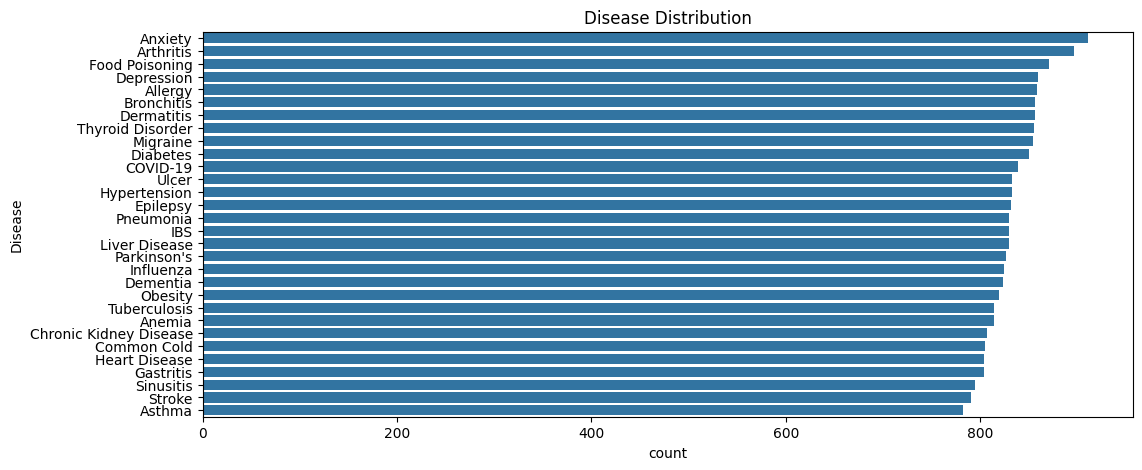

In [7]:
plt.figure(figsize=(12,5))
sns.countplot(y=df['Disease'], order=df['Disease'].value_counts().index)
plt.title("Disease Distribution")
plt.show()


In [8]:
le = LabelEncoder()
df['Disease_Encoded'] = le.fit_transform(df['Disease'])

X = df[['Age', 'Gender', 'Symptoms', 'Symptom_Count']]
y = df['Disease_Encoded']

le.classes_


array(['Allergy', 'Anemia', 'Anxiety', 'Arthritis', 'Asthma',
       'Bronchitis', 'COVID-19', 'Chronic Kidney Disease', 'Common Cold',
       'Dementia', 'Depression', 'Dermatitis', 'Diabetes', 'Epilepsy',
       'Food Poisoning', 'Gastritis', 'Heart Disease', 'Hypertension',
       'IBS', 'Influenza', 'Liver Disease', 'Migraine', 'Obesity',
       "Parkinson's", 'Pneumonia', 'Sinusitis', 'Stroke',
       'Thyroid Disorder', 'Tuberculosis', 'Ulcer'], dtype=object)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('symptoms_nlp', TfidfVectorizer(
            ngram_range=(1,2),
            max_features=5000,
            stop_words='english'
        ), 'Symptoms'),

        ('gender_nlp', TfidfVectorizer(), 'Gender')
    ],
    remainder='passthrough'
)


In [11]:
xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=8,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='multi:softmax',
        num_class=len(le.classes_),
        eval_metric='mlogloss'
    ))
])

xgb_pipeline.fit(X_train, y_train)

y_pred_xgb = xgb_pipeline.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))


XGBoost Accuracy: 0.0326
                        precision    recall  f1-score   support

               Allergy       0.04      0.05      0.05       172
                Anemia       0.02      0.02      0.02       163
               Anxiety       0.03      0.03      0.03       182
             Arthritis       0.02      0.03      0.03       179
                Asthma       0.02      0.02      0.02       156
            Bronchitis       0.03      0.04      0.03       171
              COVID-19       0.03      0.02      0.03       168
Chronic Kidney Disease       0.04      0.04      0.04       161
           Common Cold       0.07      0.07      0.07       161
              Dementia       0.06      0.05      0.06       165
            Depression       0.03      0.03      0.03       172
            Dermatitis       0.03      0.03      0.03       171
              Diabetes       0.03      0.03      0.03       170
              Epilepsy       0.06      0.05      0.06       166
        Food P

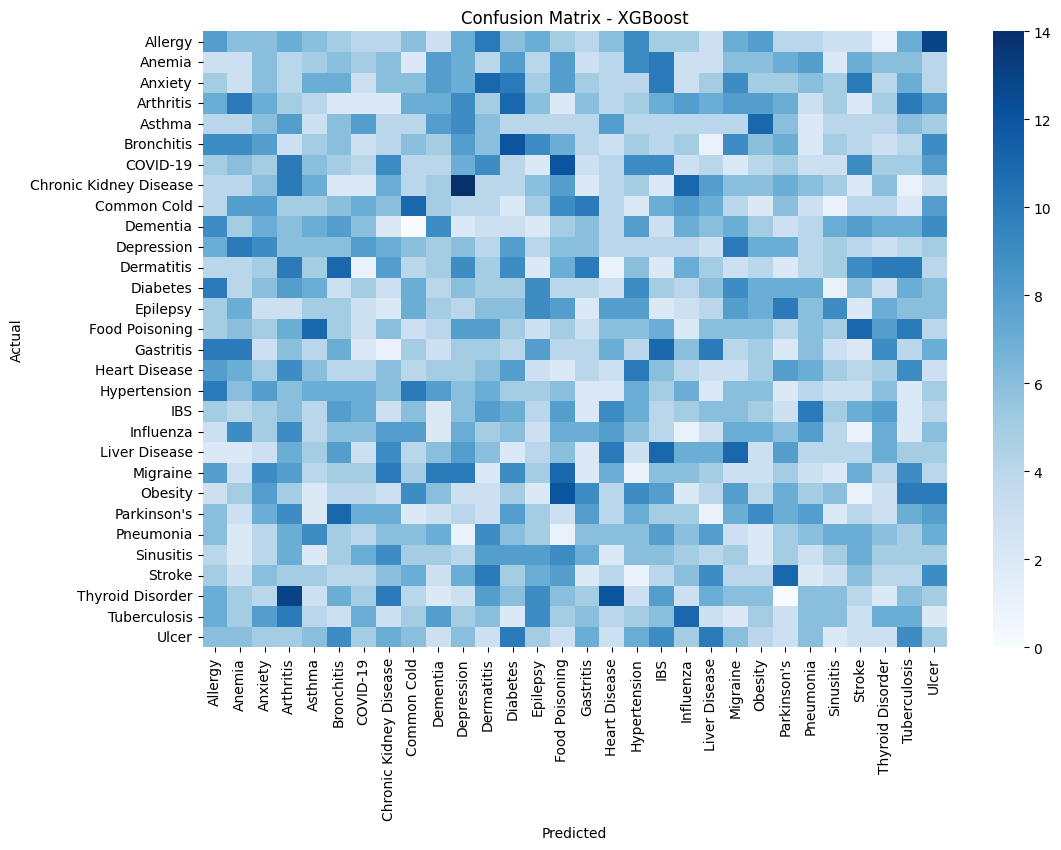

In [12]:
cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(12,8))
sns.heatmap(cm, cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [13]:
def predict_disease(age, gender, symptoms, symptom_count):
    input_data = pd.DataFrame([{
        'Age': age,
        'Gender': gender,
        'Symptoms': symptoms,
        'Symptom_Count': symptom_count
    }])
    
    pred_encoded = xgb_pipeline.predict(input_data)[0]
    return le.inverse_transform([pred_encoded])[0]


In [16]:
df.head()

,Age,Gender,Symptoms,Symptom_Count,Disease,Disease_Encoded
0,29,Male,"fever, back pain, shortness of breath",3,Allergy,0
1,76,Female,"insomnia, back pain, weight loss",3,Thyroid Disorder,27
2,78,Male,"sore throat, vomiting, diarrhea",3,Influenza,19
3,58,Other,"blurred vision, depression, weight loss, muscl...",4,Stroke,26
4,55,Female,"swelling, appetite loss, nausea",3,Heart Disease,16


In [22]:
df.tail()

,Age,Gender,Symptoms,Symptom_Count,Disease,Disease_Encoded
24995,42,Male,"runny nose, muscle pain, anxiety, depression, ...",6,Ulcer,29
24996,36,Male,"fever, blurred vision, insomnia, diarrhea, dep...",6,Common Cold,8
24997,70,Other,"anxiety, nausea, tremors",3,Anxiety,2
24998,9,Other,"muscle pain, rash, diarrhea, joint pain",4,Obesity,22
24999,27,Female,"sweating, abdominal pain, fever, insomnia, blu...",7,Parkinson's,23


In [31]:
predict_disease(
    age=45,
    gender="Male",
    symptoms="fever with high cough and lite pain in head",
    symptom_count=3
)


'Influenza'

In [30]:
import joblib

# Save the entire pipeline (preprocessing + model)
joblib.dump(xgb_pipeline, "../backend/ml_models/disease_nlp/disease_nlp_xgboost.pkl")

# Save the label encoder separately
joblib.dump(le, "../backend/ml_models/disease_nlp/disease_label_encoder.pkl")

print("✅ Model and Label Encoder saved successfully!")


✅ Model and Label Encoder saved successfully!
